<font size="1"> *This notebook is best viewed in jupyter lab/notebook. You may also choose to use Google Colab but some parts of the images/colouring will not be rendered properly.</font> 

<div class="alert alert-block alert-warning">
    
# Assignment

Welcome to your assignment! This notebook contains all the code and comments that you need to submit. The places where you need to edit are highlighted in red. Feel free to add in your own markdown for additional comments.

__Submission details: make sure you all your outputs have been generated. Submit this Jupyter Notebook.__

<b>Enter you student details below</b>

- <b>Student Name:</b> Incy Lin
- <b>Student ID:</b> 30577292

<div class="alert alert-block alert-danger">

# Table of Contents

* [Libraries](#Libraries)
    
* [Task 3.1: Download the GTSRB Train and Test set](#t3_1)
    
* [Task 3.2: Visualise a few training samples](#t3_2)
    
* [Task 3.3: Define a CNN Model](#t3_3)
    
* [Task 3.4: Train and evaluate CNN model](#t3_4)
    
* [Task 3.5: Visualise the results](#t3_5)
    
* [Task 3.6: Discussion Questions](#t3_6)

<div class="alert alert-block alert-warning">

# Libraries

Libraries are important as it saves us time from writing our own functions all the time such as graphing, or creating matrices. Brief library descriptions have been added for every library that we import. You may also check the official documentations for more details.

The required libraries are specified in this notebook for you.

In [8]:
# Mount Google Drive
import os
try:
    from google.colab import drive
    colabFlag = True
    
    PATH_DATASETS = '/content/gdrive/MyDrive/...' # Add in your own path here to the folder containing the data
    # mount Google Drive
    drive.mount('/content/gdrive')
    print(f"Using Google Colab with file path {PATH_DATASETS}")
except:
    colabFlag = False

    PATH_DATASETS = os.environ.get("PATH_DATASETS", "./data")

    print(f"Not using Google Colab. File path will be: {PATH_DATASETS}")

Not using Google Colab. File path will be: ./data


In [9]:
# If you run on google colab uncomment bellow comment
# !pip install torchmetrics pytorch-lightning torchvision -qq
# !pip install imutils

import copy
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from math import *

import torch
import torchvision
from torchvision.datasets import GTSRB
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torch.nn.functional import softmax

import lightning as pl # Pytorch lightning is a wrapper for pytorch that makes it easier to train models
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from lightning.pytorch.callbacks.progress import RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme

# from carbontracker.tracker import CarbonTracker

from torch.optim.lr_scheduler import StepLR

# Setting seeds for reproducibility
pl.seed_everything(4179)
random.seed(4179)
np.random.seed(4179)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


BATCH_SIZE = 256 if torch.cuda.is_available() else 64
# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
num_workers = 0 # Set to your device

Global seed set to 4179


<div class="alert alert-block alert-info">
    
# Image Classification on the GTSRB dataset
    
# What you should do in this task!

In this task you will be training a Convolutional Neural Network (CNN) with the GTSRB dataset using Pytorch and PyTorch Lightning funtionalities we have previously seen!

You have to use Pytorch inbuilt datasets, the Pytorch Lightning module class to construct MLP and CNN, and stochastic gradient descent (SGD) in order to perform training on the GTSRB dataset.
    
## In this task, you will work on the following points:
 1. Download the GTSRB Train and Test set
 2. Visualise a few training samples
 3. Define a CNN Model
 4. Train and evaluate CNN model
 5. Visualise the results and apply additional analysis here
 6. Discussion Questions

<img src="figures/GTSRB.jpg" width="700" align="center">

<div class="alert alert-block alert-info">
    
## Task 3.1: Download the GTSRB Train and Test set <a class="anchor" id="t3_1"></a>

The  German Traffic Sign Recognition Benchmark (GTSRB) is a a multi-class, single-image classification benchmark dataset. There are 43 classes in total, and more than over 50,000 images. There are 39,209 training examples, 12,630 test examples.

More about GTSRB dataset: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

Pytorch has constructed a number of "dataset" classes that will automatically download various datasets making it very easy for us to train our models.

In [10]:
# Define transform to convert image into a Tensor
transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Init Train DataLoader from GTSRB Dataset
train_ds = GTSRB(PATH_DATASETS, split="train", download=False, transform=transform)

# Perform Random Split for training and validation
train_ds, val_ds = random_split(train_ds, [int(len(train_ds)-math.floor(len(train_ds)*0.2)), math.ceil(int(len(train_ds)*0.2))])

val_loader = DataLoader(val_ds, shuffle=False, batch_size=BATCH_SIZE, num_workers=num_workers, pin_memory=True) 
train_loader = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE, num_workers=num_workers, pin_memory=True) 

# Init Test DataLoader from GTSRB Dataset
test_ds = GTSRB(PATH_DATASETS, split="test", download=True, transform=transform)
test_loader = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE, num_workers=num_workers, pin_memory=True) 

# Read the categories from the text file given: gtsrb_classes.txt
# This contains all 43 classes
with open(PATH_DATASETS + "/gtsrb_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# The code has been done for you in 3.1 

<div class="alert alert-block alert-info">
    
## Task 3.2: Visualise a few training samples <a class="anchor" id="t3_2"></a>
Let's first take a closer look at the shapes of the dataset, and then visualise the mini-batches that the dataloader gives us. Ensure you have reversed the normalization before plotting.

torch.Size([256, 3, 28, 28])
torch.Size([256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


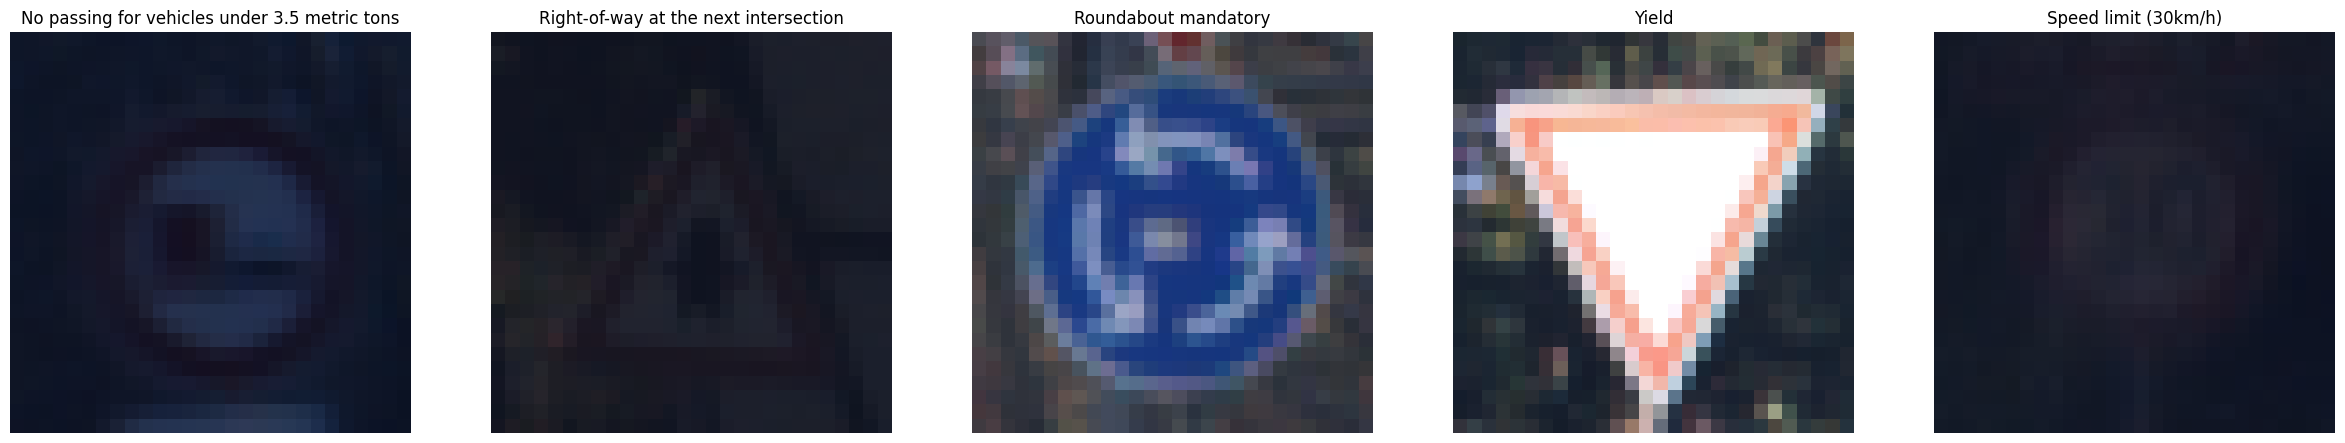

In [11]:
# Check the shapes of the batch data in train_loader
for batch in train_loader:
    print(batch[0].shape)
    print(batch[1].shape)
    break   

# Ensure you have inverse the normalization before plotting.

# Plot 5 images from the training set with their labels
fig, ax = plt.subplots(1, 5, figsize=(30, 10))
for i, (image, label) in enumerate(train_loader):
    if i == 5:
        break
    ax[i].imshow(image[0].permute(1, 2, 0).numpy() * 0.229 + 0.485)
    ax[i].set_title(categories[label[0].item()])
    ax[i].axis("off")
num_classes = 43

<div class="alert alert-block alert-info">
    
## Task 3.3: Define a CNN Model <a class="anchor" id="t3_3"></a>
    
Define the models using the LightningModule class as usual.

In [12]:
# We will use modular convolutional blocks. 
# Define a convolutional layer along with an activation function
# Remember, you can use other techniques you have learnt from the lectures and workshops such as dropout, batchnorm, pooling etc.

class ConvBlock(nn.Module):

    def __init__(self, channels_in, channels_out):
        super(ConvBlock, self).__init__()     # Call constructor
        self.conv1 = nn.Conv2d(channels_in, channels_out//2, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(channels_out//2, channels_out, 3, stride=1, padding=1)
        #activation function
        self.relu = nn.ReLU()
        #pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        #batchnorms
        self.batchnorm1 = nn.BatchNorm2d(channels_out//2)
        self.batchnorm2 = nn.BatchNorm2d(channels_out)
        

    def forward(self, x):
        
           # Conv1 -> batchnorm -> ReLU -> MaxPool2d
        x = self.conv1(x)
        x = self.relu(self.batchnorm1(x))
        x = self.pool(x)

        # Conv2 -> batchnorm -> ReLU -> MaxPool2d
        x = self.conv2(x)
        x = self.relu(self.batchnorm2(x))
        x = self.pool(x)
        
        return x

#Let's create a simple CNN for image classification
class Simple_CNN(pl.LightningModule):
    
    def __init__(self, num_classes=43, learning_rate=1e-1):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.criterion = nn.CrossEntropyLoss()
        
        # Initialise at least 2 convolutional blocks with
        self.conv_blk1 = ConvBlock(3, 128)
        self.conv_blk2 = ConvBlock(128,512)


        # You can use other layers too, feel free to define them here
        self.gap = nn.AdaptiveAvgPool2d((12, 12))
        self.relu = nn.ReLU()
        self.flat = nn.Flatten()
        self.batchnorm1 = nn.LayerNorm(64)
        self.dropout1 = nn.Dropout(0.2) 
        self.dropout2 = nn.Dropout(0.3)


        # You will need to define your fully connected layer:
        self.fc1 = nn.Linear(512,256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,num_classes)

        # Define your accuracies        
        self.train_accuracy = Accuracy(task='multiclass', num_classes=num_classes)
        self.val_accuracy = Accuracy(task='multiclass', num_classes=num_classes)
        self.test_accuracy = Accuracy(task='multiclass', num_classes=num_classes)
        
    def forward(self, x):
        x=self.conv_blk1(x)
        x=self.conv_blk2(x)
        # print("after convblk2:", x.shape)
        x = self.flat(x)
        x = self.fc1(x)
        # print("after fc1:", x.shape)
        x = self.dropout2(x)
        # print("after dropout2:", x.shape)
        x = self.fc2(x)
        # print("after fc2:", x.shape)
        x = self.batchnorm1(x)
        x = self.dropout1(x)
        x = self.fc3(x)

        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        preds = logits.argmax(1)
        self.train_accuracy.update(preds, y)
        
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_accuracy", self.train_accuracy, prog_bar=True, on_step=False, on_epoch=True)

        return loss


    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        preds = logits.argmax(1)
        self.val_accuracy.update(preds, y)

        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_accuracy", self.val_accuracy, prog_bar=True, on_step=False, on_epoch=True)
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        preds = logits.argmax(1)
        self.test_accuracy.update(preds, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_accuracy", self.test_accuracy, prog_bar=True)  
        return preds, y, x # Return the predictions, labels and images for visualisation
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    ##########
    # DATA RELATED HOOKS
    ##########

    def train_dataloader(self):
        return train_loader
    def val_dataloader(self):
        return val_loader
    def test_dataloader(self):
        return test_loader

<div class="alert alert-block alert-info">
    
## Task 3.4: Train and evaluate CNN model <a class="anchor" id="t3_4"></a>
    
Define VisualizeSamplePredictionsCallback using Callback class. You have to visualise 4 sample predictions from the first batch at the end of testing. This will redefine the on_test_batch_end function.

Here is a sample image:
    
<img src="figures/sample_predictions_reel.png" width="700" align="center">

Make sure to display actual category of Ground truth and Prediction by reading the given text file.
   
    
In PyTorch Lightning, callback functions are used to customize and extend the behavior of your training loops without cluttering your main code. Callbacks are objects that you can attach to your LightningModule and customize various aspects of the training process, such as logging, early stopping, model checkpointing, and more. We are updating the callback of the  the _on_test_batch_end method derived from the pytorch lightning module.

In [78]:
class VisualizeSamplePredictionsCallback(Callback):
    
    def on_test_batch_end(
        self, trainer, pl_module, outputs, batch, batch_idx):
        """Called when the test batch ends."""
 
        # `outputs` comes from `LightningModule.test_step`, so make sure to return prediction in test_step 
        # which corresponds to our model predictions during testing time in this case
        # Let's log 4 sample image predictions from first batch
        # Make sure to do inverse normalizing before you plot original images
        # Also, make sure to display corresponding actual class name for ground truth and prediction
        
        # You can ignore the input "dataloader_id"
        if batch_idx == 0:

            x, y = batch

            # If you are using cuda, then you need to use the three lines below
            # x = x.cpu() 
            # y = y.cpu()
            # outputs = outputs.cpu()

        fig, ax = plt.subplots(1, 4, figsize=(20, 20))
            
        # preds= outputs[0][0]
        # labels = outputs[0][1]    
        # inputs= outputs[0][2]
        for i in range(5):
            actual = outputs[i][1]
            pred = outputs[i][0]
            ax[i].set_title(f'Actual: {actual} ({categories[actual]})\nPredicted: {pred} ({categories[pred]})') # Set the title for the subplot
            ax[i].imshow(outputs[i][2])    # Display the image in the subplot


In [91]:
# Initialize the CNN model
max_epochs = 50 # Feel free to change this
model_cnn = Simple_CNN()

# Initialize checkpoint callback to save the best model using validation loss
checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints_section_3/",
        save_top_k=1,        
        mode="min",
        every_n_epochs=1
    )

# Create customized progress bar theme (Optional)
progress_bar_task = RichProgressBar(refresh_rate=1, leave=True,
    theme=RichProgressBarTheme(
        description="green_yellow",
        progress_bar="green1",
        progress_bar_finished="green1",
        progress_bar_pulse="#6206E0",
        batch_progress="green_yellow",
        time="grey82",
        processing_speed="grey82",
        metrics="grey82"
    )
)

# Stop after 5 epochs of no improvement in validation loss
early_stopping = EarlyStopping('val_loss', patience = 5, mode='min') 

# Call the Trainer and train the model
trainer_task = pl.Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=max_epochs,
    callbacks=[progress_bar_task, checkpoint_callback, early_stopping], #removed visualizesamplepredictionscallback to fix error for not best path
    logger=CSVLogger(save_dir="logs_task_3"),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [92]:
# Train the model
trainer_task.fit(model_cnn)

c:\Users\winky\Documents\ECE4179\.venv\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory C:\Users\winky\Documents\ECE4179\ECE4179_Assignment_2023\checkpoints_section_3 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name           ┃ Type               ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ criterion      │ CrossEntropyLoss   │      0 │
│ 1  │ conv_blk1      │ ConvBlock          │ 76.0 K │
│ 2  │ conv_blk2      │ ConvBlock          │  1.5 M │
│ 3  │ gap            │ AdaptiveAvgPool2d  │      0 │
│ 4  │ relu           │ ReLU               │      0 │
│ 5  │ flat           │ Flatten            │      0 │
│ 6  │ batchnorm1     │ LayerNorm          │    128 │
│ 7  │ dropout1       │ Dropout            │      0 │
│ 8  │ dropout2       │ Dropout            │      0 │
│ 9  │ fc1            │ Linear             │  131 K │
│ 10 │ fc2            │ Linear             │ 16.4 K │
│ 11 │ fc3            │ Linear             │  2.8 K │
│ 12 │ train_accuracy │ MulticlassAccuracy │      0 │
│ 13 │ val_accuracy   │ MulticlassAccuracy │      0 │
│ 14 │ test_accuracy  │ MulticlassAccuracy │      0 │
└────┴────────────────┴────────────────────┴────────┘

Trainable params: 1.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.7 M                                                                                                
Total estimated model params size (MB): 6

Output()

c:\Users\winky\Documents\ECE4179\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:438
: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in
the `DataLoader` init to improve performance.
  rank_zero_warn(

c:\Users\winky\Documents\ECE4179\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:438
: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in
the `DataLoader` init to improve performance.
  rank_zero_warn(

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [93]:
# Test the model and report test accuracy and test loss
trainer_task.test()

Restoring states from the checkpoint path at C:\Users\winky\Documents\ECE4179\ECE4179_Assignment_2023\checkpoints_section_3\epoch=16-step=1428.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at C:\Users\winky\Documents\ECE4179\ECE4179_Assignment_2023\checkpoints_section_3\epoch=16-step=1428.ckpt


Output()

c:\Users\winky\Documents\ECE4179\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9036421179771423     │
│         test_loss         │    0.8638615608215332     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.8638615608215332, 'test_accuracy': 0.9036421179771423}]

<div class="alert alert-block alert-info">
    
## Task 3.5: Visualise the results and apply additional analysis here <a class="anchor" id="t3_5"></a>

Using log files and matplotlib, plot train loss, validation loss, train accuracy, and validation accuracy.

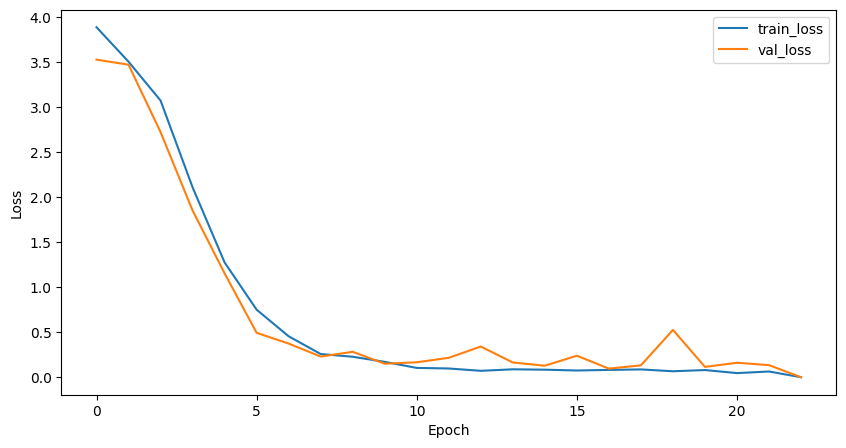

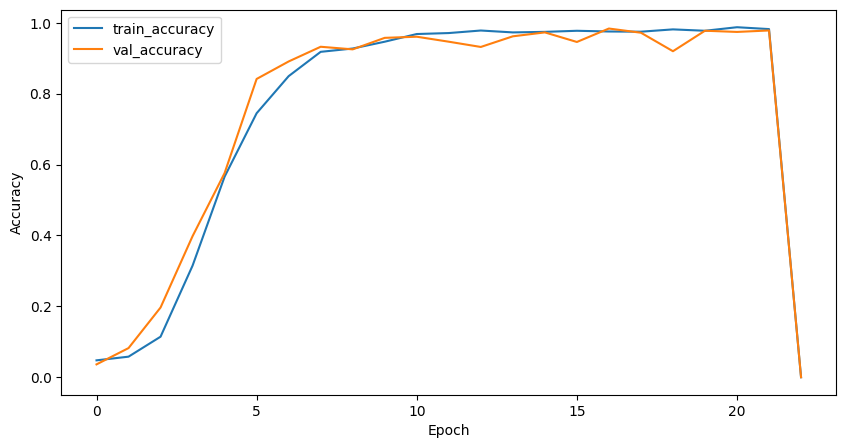

In [94]:
# Show the CNN training and validation curves.
# You can use your own way of logging if you do not want to use tensorboard.
metrics_task = pd.read_csv(trainer_task.logger.log_dir + "/metrics.csv")
metrics_task.set_index("epoch", inplace=True)
metrics_task = metrics_task.groupby(level=0).sum().drop("step", axis=1)

#Plot train loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(metrics_task["train_loss"], label="train_loss")
plt.plot(metrics_task["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

#Plot train accuracy and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(metrics_task["train_accuracy"], label="train_accuracy")
plt.plot(metrics_task["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Add in your other analysis here. You can choose two (or more) of the following (or any others that are not on this list):

- Feature maps at the outputs of each __CNN block__ for a correctly classified road sign
- Saliency map on a correctly classified road sign
- Top 5 incorrectly classified road signs
- Occlusion sensitivity on a few images
- Confusion matrix on a subset of classes (~15 classes)

In [1]:
predictions = trainer_task.predict(model_cnn, test_loader) # do not do anything to the variable 'predictions' you will reuse it

test_outputs = torch.concat([prediction[0] for prediction in predictions], dim=0)
test_labels = torch.concat([prediction[1] for prediction in predictions], dim=0)
test_inputs = torch.concat([prediction[2] for prediction in predictions], dim=0)
test_preds = test_outputs.argmax(dim=1)
#Top 5 incorrectly calssified road signs
SIZE=5
# Loop through each class (category)
#Craete a list of 10 lists to store the incorrect predictions for each class
fig, axes=plt.subplots(num_classes, SIZE, figsize=(15, 15))
print('Top 5 Misclassifications for Each Class')
incorrect_for_each_class = [[] for i in range(num_classes)]
for c in range(num_classes):
    for i in range(len(test_preds)):
        if test_labels[i]==c:
            if test_preds[i]!=test_labels[i]:
            #append max softmax probability, predicted label, actual label,and input image to the list
                incorrect_for_each_class[c].append([max(softmax(test_outputs[i].float())), test_preds[i], test_labels[i], test_inputs[i]])
#Get the 5 largest probabilities for each class
for c in range(num_classes):
    #sort the list of correct predictions for each class by the softmax probability
    incorrect_for_each_class[c].sort(key=lambda x: x[0], reverse=True)
    #get the 5 largest probabilities
    largest_5 = incorrect_for_each_class[c][:SIZE]
    #print(largest_5)
    #plot the 5 largest probabilities for each class
    for i in range(SIZE):
        #print(largest_5[i][3].shape)
        #print(largest_5[i][3].permute(1, 2, 0).shape)
        prob = largest_5[i][0]*100
        axes[c][i].set_title(f'Actual: {categories[largest_5[i][2]]}\nPredicted: {categories[largest_5[i][1]]} ({prob:.2f}%)') # Set the title for the subplot
        axes[c][i].imshow(largest_5[i][3].permute(1, 2, 0), cmap='gray')    # Display the image in the subplot

NameError: name 'trainer_task' is not defined

<div class="alert alert-block alert-success">
    
## Task 3.6: Discussion Questions <a class="anchor" id="t3_6"></a>
    
## Questions
    
1. List the different ways you have tried to optimize your model and discuss why you chose those methods.

2. Show how you calculated the input size of the fully connected layer right after all the convolutional blocks. 

3. Please talk and discuss about the first additional analysis you have performed. What can you deduce from the analysis?

4. Please talk and discuss about the second additional analysis you have performed. What can you deduce from the analysis?
    

    
## Answers

1. I tried out different values for the dropout functions. These values are important as they determine how big the weights of neurons can get. 

2. The input size of my first fully connected layer was the output size of my second convolutional block

3. 

4. 
